This notebook is for analysing the patient presence at the hospitals.

Result should be, for each patient:
- a list of 61 days marked with a 0
- the middle day is matched with the surgery action date and marked with a 1
- any other inpatient or outpatient days for the same case to be marked with a 1
- this yields a square signal for patient's attendance

In [1]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data File:

In [2]:
file_name = 'tiny.csv'
file_name = 'aaaPas 2024-05-15.csv'
# Read in Data File
df = pd.read_csv(file_name)
display(df.head(4))

for sl_no, name in enumerate(df.columns):
    print("{}:\t{}".format(sl_no, name))

print(df["val_lopnr"].iloc[-1])

/tmp/ipykernel_12845/3793240382.py:4: DtypeWarning: Columns (27,28,29,30,31,32,33,34,43,44,45,46,47,48,49,50,51,52,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


,ID,lopnr,val_lopnr,birth_year_month,Sex,RefActionDate,DocumentID,IsReference,TimestampSaved,SavedAtCareUnitID,...,ActionCode18,ActionCode19,ActionCode20,ActionCode21,ActionCode22,Mosaic,Usaett,LastMoveDate,LastMoveDirection,NumberOfEarlierVisits
0,296473,97508,1,01/08/1942,K,15/03/2020,3277,1,16/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,1.Bttre bemedlade,1.0,NaN,NaN,8.0
1,294480,97508,1,01/08/1942,K,15/03/2020,3485,0,24/03/2020,4264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2,293891,97508,1,01/08/1942,K,15/03/2020,3547,0,24/03/2020,5065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,296589,97508,1,01/08/1942,K,15/03/2020,3552,0,27/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


0:	ID
1:	lopnr
2:	val_lopnr
3:	birth_year_month
4:	Sex
5:	RefActionDate
6:	DocumentID
7:	IsReference
8:	TimestampSaved
9:	SavedAtCareUnitID
10:	NameOfCareUnit
11:	IsInpatient
12:	StartDatetime
13:	EmergencyID
14:	DischargeDateTime
15:	DiagnosisCode1
16:	DiagnosisCode2
17:	DiagnosisCode3
18:	DiagnosisCode4
19:	DiagnosisCode5
20:	DiagnosisCode6
21:	DiagnosisCode7
22:	DiagnosisCode8
23:	DiagnosisCode9
24:	DiagnosisCode10
25:	DiagnosisCode11
26:	DiagnosisCode12
27:	DiagnosisCode13
28:	DiagnosisCode14
29:	DiagnosisCode15
30:	DiagnosisCode16
31:	DiagnosisCode17
32:	DiagnosisCode18
33:	DiagnosisCode19
34:	DiagnosisCode20
35:	DiagnosisCodePre1
36:	DiagnosisCodePre2
37:	DiagnosisCodePre3
38:	DiagnosisCodePre4
39:	DiagnosisCodePre5
40:	DiagnosisCodePre6
41:	DiagnosisCodePre7
42:	DiagnosisCodePre8
43:	DiagnosisCodePre9
44:	DiagnosisCodePre10
45:	DiagnosisCodePre11
46:	DiagnosisCodePre12
47:	DiagnosisCodePre13
48:	DiagnosisCodePre14
49:	DiagnosisCodePre15
50:	DiagnosisCodePre16
51:	DiagnosisCodePr

### Make a container to hold square waves.

In [3]:
# Number of patients: last serial number in 'val_lopnr'
# 1 time string per patient
# time string length is 30 days before and after 'RefActionDate' for that patient = when surgery was performed
# time string length = 30 + 30 + 1 = 61
time_str_len = 61
num_patients = df['val_lopnr'].to_numpy()[-1]+1
time_strings = np.zeros((num_patients, time_str_len))
ts = time_strings[0,:]
print(np.shape(ts))
# print(np.shape(time_strings))

(61,)


In [4]:
event_start_dates = df.loc[df['val_lopnr']==1]['StartDatetime']
event_end_dates = df.loc[df['val_lopnr']==1]['DischargeDateTime'].fillna(0)

# print(event_start_dates)
# print(event_end_dates)

In [5]:
# Assign a name for RefActionDate 
idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==1]['RefActionDate'][0], dayfirst=True)

# Set midpoint of list to RefActionDate
mid_point = 30
ts[mid_point] = 1

for i, j in zip(event_start_dates, event_end_dates):
    x = pd.to_datetime(i, dayfirst=True)
    print(x)
    print((x-idx30_date).days)
    start_offset = (x-idx30_date).days
    ts[mid_point + start_offset] = 1
    if j!=0: # When inpatient
        y = pd.to_datetime(j, dayfirst=True)
        print(y)
        print('interval is {}'.format((y-x).days))
        end_offset = (y-x).days
        ts[mid_point + start_offset : mid_point + start_offset + end_offset + 1] = 1
    else: # Delta when outpatient
        print(0)
    print('---')

2020-03-08 00:00:00
-7
2020-03-15 00:00:00
interval is 7
---
2020-03-20 00:00:00
5
0
---
2020-03-21 00:00:00
6
2020-03-23 00:00:00
interval is 2
---
2020-03-23 00:00:00
8
2020-03-26 00:00:00
interval is 3
---


In [6]:
def gen_dirac_timeseries(idx30_date, eventStarts, eventEnds):
    # Set midpoint of list to RefActionDate
    mid_point = 30
    ts = np.zeros(61)
    ts[mid_point] = 1
    
    for i, j in zip(event_start_dates, event_end_dates):
        x = pd.to_datetime(i, dayfirst=True)
        # print(x)
        # print((x-idx30_date).days)
        start_offset = (x-idx30_date).days
        # Always set event Start Date to 1, whether inpatient or outpatient
        ts[mid_point + start_offset] = 1
        if j!=0: # When inpatient
            y = pd.to_datetime(j, dayfirst=True)
            # print(y)
            # print('interval is {}'.format((y-x).days))
            end_offset = (y-x).days
            ts[mid_point + start_offset : mid_point + start_offset + end_offset + 1] = 1
        else: # Delta when outpatient
            None
            # print(0)
        # print('---')    
    return ts

In [13]:
num_missing_patients = 0
patient_count_bound = 20000# num_patients
for i in range(12, patient_count_bound):
    try: 
        print(' ')
        # chunk = df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0]
        # print(chunk)
        # print(chunk[0])
        print('aaa')
        idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0], dayfirst=True)
        # print(idx30_date)
        
        print('bbb')
        event_start_dates = df.loc[df['val_lopnr']==i]['StartDatetime']
        
        print('ccc')
        event_end_dates = df.loc[df['val_lopnr']==i]['DischargeDateTime'].fillna(0)
        
        print('ddd')
        time_strings[i, :] = gen_dirac_timeseries(idx30_date, event_start_dates, event_end_dates)
    except Exception as a:
        num_missing_patients += 1
        print(i)
        print(a)
        if num_missing_patients > 4:
            break
print('Total number of missing patients = {}/{}'.format(num_missing_patients, patient_count_bound))

 
aaa
12
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
26
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
32
index 64 is out of bounds for axis 0 with size 61
 
aaa
33
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
37
single positional indexer is out-of-bounds
Total number of missing patients = 5/20000


Notes:
1. If patient number is missing there is an error: `single positional indexer is out-of-bounds`
2. If patient diagnosis does not exist, there is an error: `index 64 is out of bounds for axis 0 with size 61`

(260993, 61)


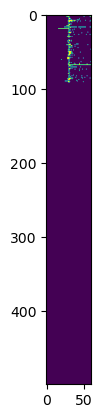

In [8]:
num_patients = 500
print(np.shape(time_strings))
plt.figure()
plt.imshow(time_strings[0:max(20, num_patients),:])
plt.show()

In [9]:
import pickle
data_dump_filename = "time_strings_20k.pickle"

with open(data_dump_filename, 'wb') as fh:
    pickle.dump(time_strings, fh)

### TODO
1. Clean up the dataframe of missing serial numbers
2. Find a better plotting to visualise all the time_strings together